In [9]:
import requests as r
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import yfinance as yf
import pandas_ta as ta

In [10]:
# Downloading the BTC_USD data from yfinance api 
df = yf.download('BTC-USD', period='10y', interval='1d')
df.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-07-18,64104.738281,65104.660156,63246.164062,63974.066406,63974.066406,27239305337
2024-07-19,63972.324219,67442.640625,63329.343750,66710.156250,66710.156250,37003855410
2024-07-20,66709.921875,67610.734375,66299.617188,67163.648438,67163.648438,19029581250
2024-07-21,67164.914062,68372.906250,65842.296875,68154.523438,68154.523438,26652190004
2024-07-22,68167.937500,68418.554688,67092.687500,67451.164062,67451.164062,31022811136


In [11]:
df.shape

(3597, 6)

In [12]:
# Some technical analysis indicators that helps improving the model accuracy
df['RSI']=ta.rsi(df.Close, length=15)
df['EMAF']=ta.ema(df.Close, length=20)
df['EMAM']=ta.ema(df.Close, length=100)
df['EMAS']=ta.ema(df.Close, length=150)

# Taking the "Adj Close" value of the next row(day)
df["NextClose"] = df["Adj Close"].shift(-1)
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)
df.drop(["Close", "Volume"], axis=1, inplace=True)
df.head()

,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,NextClose
0,221.968994,240.259003,221.261993,235.427002,50.019072,229.312807,288.640505,327.932773,257.321014
1,235.528000,259.808014,235.528000,257.321014,58.174526,231.980256,288.020317,326.997518,234.824997
2,257.506989,265.610992,227.684006,234.824997,49.315763,232.251183,286.966944,325.776690,233.843002
3,234.824997,239.520996,229.022003,233.843002,48.967016,232.402785,285.914985,324.559025,243.610001
4,233.421997,245.774994,232.313995,243.610001,52.543343,233.470139,285.077263,323.486853,236.326004


In [13]:
df.tail()

,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,NextClose
3442,65091.832031,66066.734375,63896.085938,64118.792969,57.705949,61042.545530,62698.871191,60844.085959,63974.066406
3443,64104.738281,65104.660156,63246.164062,63974.066406,57.218043,61321.737994,62724.122581,60885.542654,66710.156250
3444,63972.324219,67442.640625,63329.343750,66710.156250,63.473619,61834.920685,62803.053941,60962.689854,67163.648438
3445,66709.921875,67610.734375,66299.617188,67163.648438,64.398068,62342.418567,62889.402347,61044.821756,68154.523438
3446,67164.914062,68372.906250,65842.296875,68154.523438,66.389492,62895.952364,62993.662170,61138.989990,67451.164062


In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = scaler.fit_transform(df)

In [15]:
scaled_df.shape

(3447, 9)

In [16]:
def create_sequences(df, seq_length):
    sequences = []
    labels = df[seq_length: ,-1]
    for i in range(seq_length, len(df)):
        sequences.append(df[i-seq_length: i, :8])
        
    return np.array(sequences), np.array(labels)

In [17]:
seq_length = 10
X, y = create_sequences(scaled_df, seq_length)
y = np.reshape(y, (len(y), 1))

In [18]:
X.shape

(3437, 10, 8)

In [19]:
y.shape

(3437, 1)

In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [21]:
X_train.shape

(2749, 10, 8)

In [22]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

In [23]:
model = Sequential()

model.add(LSTM(150, return_sequences=False, activation="tanh",  input_shape=(seq_length, 8)))

model.add(Dense(1, activation="linear"))

model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150)               95400     
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 95,551
Trainable params: 95,551
Non-trainable params: 0
_________________________________________________________________


In [24]:
hist = model.fit(X_train, y_train, epochs=200, batch_size=32, shuffle=False, validation_split=0.1)

Epoch 1/200
78/78 [==============================] - 2s 8ms/step - loss: 0.0035 - val_loss: 0.0194
Epoch 2/200
78/78 [==============================] - 0s 4ms/step - loss: 0.0044 - val_loss: 0.0093
Epoch 3/200
78/78 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0014
Epoch 4/200
78/78 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 9.5293e-04
Epoch 5/200
78/78 [==============================] - 0s 5ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 6/200
78/78 [==============================] - 0s 5ms/step - loss: 0.0013 - val_loss: 8.9649e-04
Epoch 7/200
78/78 [==============================] - 0s 5ms/step - loss: 7.8427e-04 - val_loss: 0.0027
Epoch 8/200
78/78 [==============================] - 0s 5ms/step - loss: 7.0033e-04 - val_loss: 0.0029
Epoch 9/200
78/78 [==============================] - 0s 5ms/step - loss: 6.9959e-04 - val_loss: 0.0024
Epoch 10/200
78/78 [==============================] - 0s 5ms/step - loss: 7.1082e-04 - va

In [25]:
y_pred = model.predict(X_test)
for i in range(10):
    print(y_pred[i], y_test[i])

22/22 [==============================] - 0s 3ms/step
[0.2500462] [0.2713792]
[0.24681813] [0.2689868]
[0.2494111] [0.25561143]
[0.24615249] [0.26182301]
[0.23386425] [0.26236518]
[0.23983786] [0.2905144]
[0.2375111] [0.29462274]
[0.2750237] [0.29584015]
[0.2749961] [0.30409003]
[0.28254297] [0.2756331]


In [26]:
y_test_copy = y_test.copy()

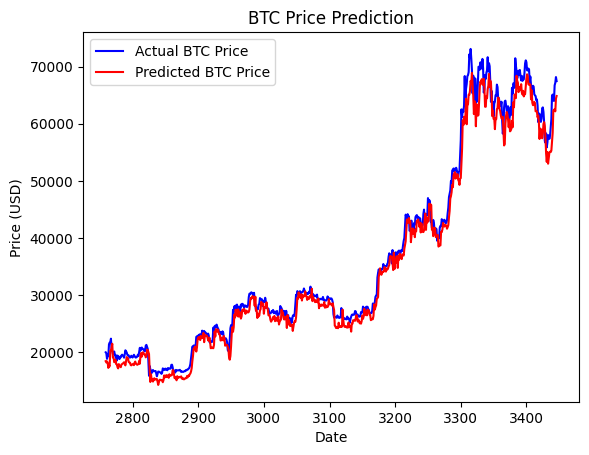

In [27]:
# Plotting the acctual prices and predicted prices together
predictions = scaler.inverse_transform(np.hstack( (np.zeros((y_pred.shape[0], 8)), y_pred)))[:, -1]
y_test_actual = scaler.inverse_transform(np.hstack((np.zeros((y_test_copy.shape[0], 8)), y_test_copy.reshape(-1, 1))))[:, -1]

plt.plot(df.index[-len(y_test):], y_test_actual, color='blue', label='Actual BTC Price')
plt.plot(df.index[-len(y_test):], predictions, color='red', label='Predicted BTC Price')
plt.title('BTC Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

predicted_prices = np.array(y_pred)
accutal_prices = np.array(y_test)

mae = mean_absolute_error( accutal_prices, predicted_prices)
print(f"Mean Absolute Error: {mae}")

mse = mean_squared_error(accutal_prices, predicted_prices)
print(f"Mean Squared Error: {mse}")

r2 = r2_score(accutal_prices, predicted_prices)
print(f"R2 Score: {r2}")

Mean Absolute Error: 0.02280658026573856
Mean Squared Error: 0.000900048578801504
R2 Score: 0.9838063481818918


In [39]:
path = "C:/Users/Batlagh/models/btc_price_pred/btc_price_pred.h5"
model.save(path)

In [40]:
import tensorflow as tf
path = "C:/Users/Batlagh/models/btc_price_pred/btc_price_pred.h5"
model = tf.keras.models.load_model(path)

In [41]:
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas_ta as ta
import warnings
warnings.filterwarnings('ignore')


# Predicting today and tomorrow's prices
seq_length = 10
def predict_tomorrow():
    # Preparing necessary data for prediction
    df = yf.download('BTC-USD', period='6mo', interval='1d')
    
    df['RSI']=ta.rsi(df.Close, length=15)
    df['EMAF']=ta.ema(df.Close, length=20)
    df['EMAM']=ta.ema(df.Close, length=100)
    df['EMAS']=ta.ema(df.Close, length=150)
    
    df.dropna(inplace=True)
    df.reset_index(inplace=True, drop=True)
    df.drop(["Close", "Volume"], axis=1, inplace=True)
    df["NextClose"] = 0    

    # Scaling data using MinMaxScaler
    scaled_data = scaler.transform(df)
    scaled_data = np.delete(scaled_data, -1, axis=1)

    # Creating sequence for predicting today's price
    latest_sequence = np.array([scaled_data[-seq_length-1:-1]])
    today_pred_scaled = model.predict(latest_sequence)

    # Creating sequence for predicting tomorrow's price
    new_sequence = np.array([scaled_data[-seq_length:]])
    tomorrow_pred_scaled = model.predict(new_sequence)

    # Inversing scaled Prices
    today_prediction = scaler.inverse_transform(
        np.hstack((np.zeros((today_pred_scaled.shape[0], 8)), today_pred_scaled))
    )[:, -1]

    tomorrow_prediction = scaler.inverse_transform(
        np.hstack((np.zeros((tomorrow_pred_scaled.shape[0], 8)), tomorrow_pred_scaled))
    )[:, -1]
    
    return today_prediction, tomorrow_prediction

predicted_prices = predict_tomorrow()
print(f"today's predicted price: {predicted_prices[0]} \ntomorrow's predicted price: {predicted_prices[1]}")

[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 18ms/step
today's predicted price: [65810.91811938] 
tomorrow's predicted price: [65413.04714612]
